# EDA

## Data Loading

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# --------------------------------------------------
# Data Loading
# --------------------------------------------------
df = pd.read_csv("cure_all_cancers_data_treatment.csv")

print("Dataset shape:", df.shape)
df.head()

# --------------------------------------------------
# Boolean feature encoding (representation choice)
# --------------------------------------------------
# For distance-based models, boolean indicators are
# encoded as 0/1 so that each mismatch contributes
# equally to distance. This does not modify data content.
bool_cols = df.select_dtypes(include="bool").columns
df[bool_cols] = df[bool_cols].astype(int)


Dataset shape: (418, 37)


## Data Shape

In [18]:
n_obs, n_features = df.shape
print(f"Number of observations: {n_obs}")
print(f"Number of features: {n_features}")

Number of observations: 418
Number of features: 37


## Label balance

Label counts:
 has_cancer
0    343
1     75
Name: count, dtype: int64

Label proportions:
 has_cancer
0    0.820574
1    0.179426
Name: proportion, dtype: float64


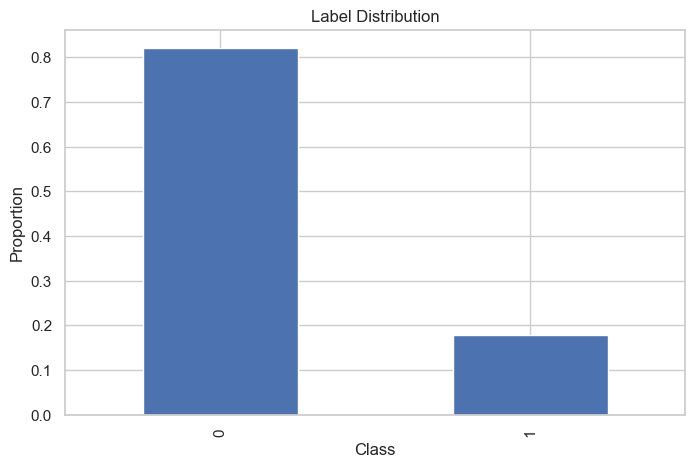

In [19]:
label_col = "has_cancer"

label_counts = df[label_col].value_counts()
label_props = df[label_col].value_counts(normalize=True)

print("Label counts:\n", label_counts)
print("\nLabel proportions:\n", label_props)

label_props.plot(kind="bar")
plt.title("Label Distribution")
plt.ylabel("Proportion")
plt.xlabel("Class")
plt.show()


## Missingness per feature

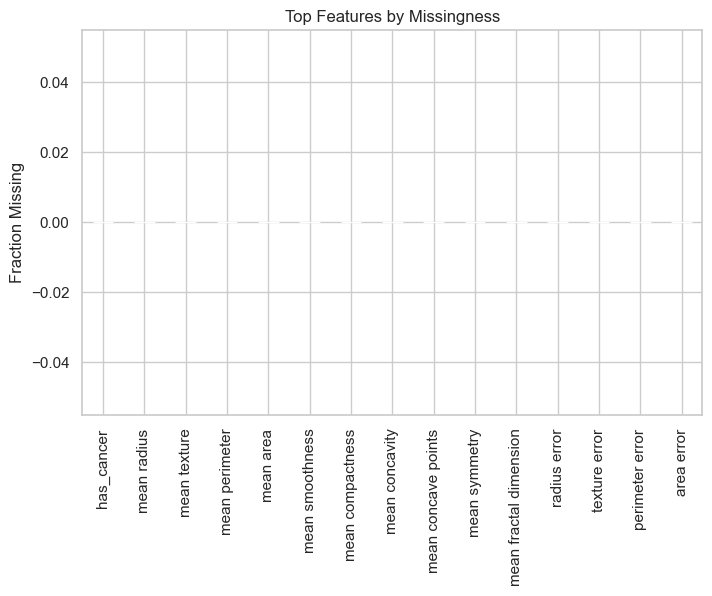

In [20]:
missing_pct = df.isna().mean().sort_values(ascending=False)

missing_summary = pd.DataFrame({
    "missing_fraction": missing_pct,
    "missing_count": df.isna().sum()
})

missing_summary

missing_pct.head(15).plot(kind="bar")
plt.title("Top Features by Missingness")
plt.ylabel("Fraction Missing")
plt.show()


## Feature distributions

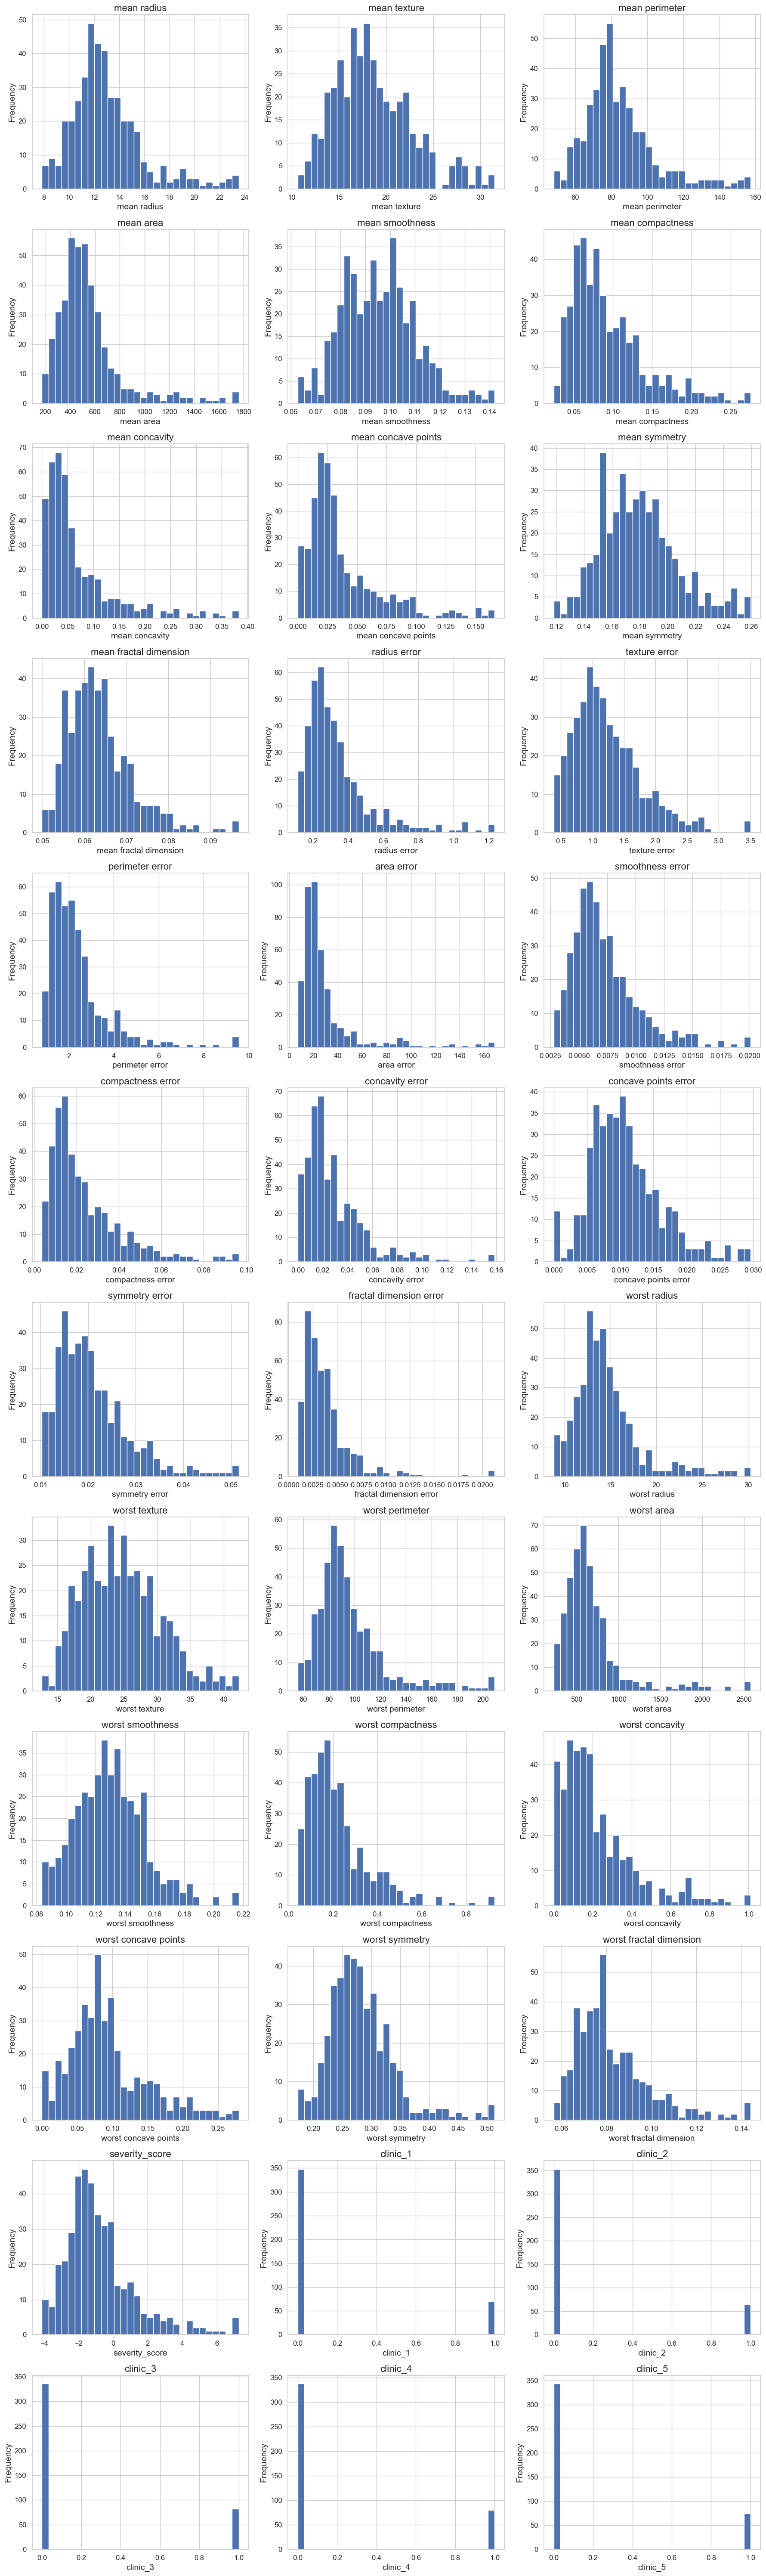

In [23]:
# --------------------------------------------------
# Global plotting configuration
# --------------------------------------------------
plt.rcParams.update({
    "figure.figsize": (14, 10),
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# Histograms in a grid
import math

numeric_features = df[feature_cols].select_dtypes(include="number").columns

n_cols = 3
n_rows = math.ceil(len(numeric_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, numeric_features):
    ax.hist(df[col], bins=30)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

# Remove empty subplots
for ax in axes[len(numeric_features):]:
    ax.remove()

plt.tight_layout()
plt.show()


## Correlation heatmap

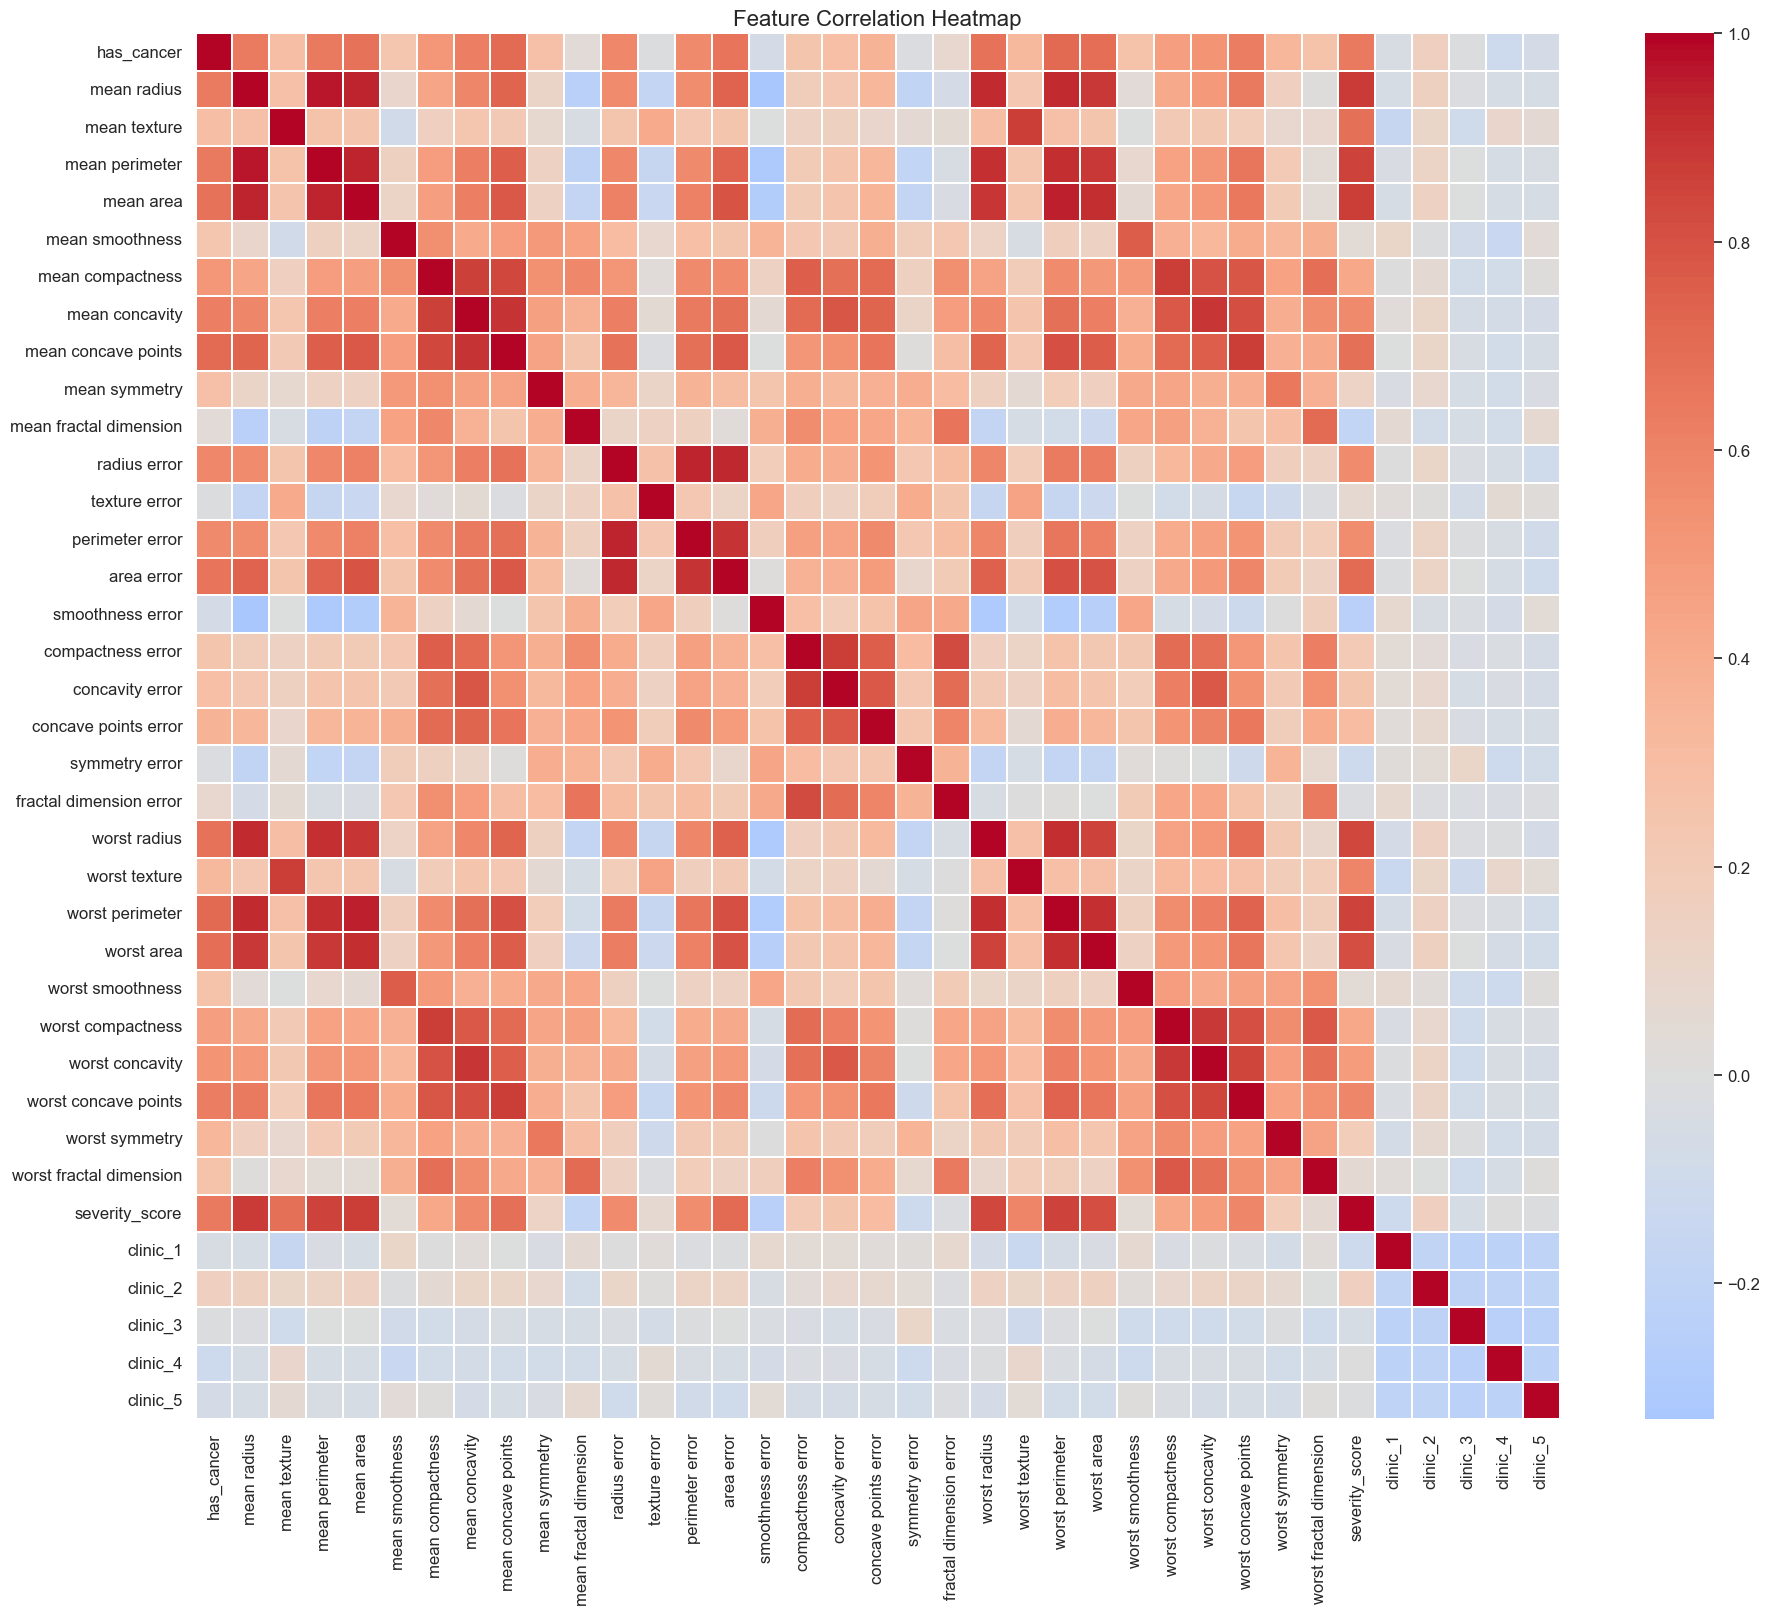

In [34]:
# --------------------------------------------------
# Global plotting configuration (easy to tune)
# --------------------------------------------------
PLOT_CONFIG = {
    "figsize": (22, 18),
    "title_size": 18,
    "tick_size": 18,
    "label_rotation_x": 90,
    "label_rotation_y": 0,
    "line_width": 0.3,
    "cbar_shrink": 0.8
}

corr_cols = ["has_cancer"] + feature_cols.tolist()
corr = df[corr_cols].corr()

plt.figure(figsize=PLOT_CONFIG["figsize"])
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.3
)
plt.title("Feature Correlation Heatmap")
plt.show()


# KNN Model

## Data Splitting

In [37]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# -----------------------------
# Load data (edit target name if needed)
# -----------------------------
df = pd.read_csv("cure_all_cancers_data_treatment.csv")

label_col = "has_cancer"
y = df[label_col]
X = df.drop(columns=[label_col])

# -----------------------------
# Train/test split (single holdout test set)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # good for classification to preserve class balance
)


## Data Transformation
  - Exclude binary features
  - Log transformation
  - Yeo–Johnson
  - StandardScaler
  - SImple xample

In [72]:
# -----------------------------
# Column detection helpers (binary vs continuous)
# -----------------------------
def detect_binary_cols(df: pd.DataFrame):
    bin_cols = []
    for c in df.columns:
        if not np.issubdtype(df[c].dtype, np.number):
            continue
        vals = df[c].dropna().unique()
        if len(vals) == 2 and set(vals).issubset({0, 1}):
            bin_cols.append(c)
    return bin_cols

def detect_nonneg_skew_cols(df: pd.DataFrame, exclude_cols, skew_thresh=1.0):
    cols = []
    num_df = df.select_dtypes(include=[np.number])
    for c in num_df.columns:
        if c in exclude_cols:
            continue
        # Only safe for log/log1p if all values are >= 0
        if num_df[c].min(skipna=True) >= 0:
            sk = num_df[c].skew()
            if np.isfinite(sk) and abs(sk) > skew_thresh:
                cols.append(c)
    return cols

def detect_other_continuous_cols(df: pd.DataFrame, exclude_cols):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in num_cols if c not in exclude_cols]

binary_cols = detect_binary_cols(X_train)
log_cols = detect_nonneg_skew_cols(X_train, exclude_cols=binary_cols, skew_thresh=1.0)
other_cont_cols = detect_other_continuous_cols(X_train, exclude_cols=binary_cols + log_cols)

print("Binary cols:", binary_cols)
print("Log1p cols (nonneg & skewed):", log_cols)
print("Yeo-Johnson cols (other numeric):", other_cont_cols)

# -----------------------------
# Preprocess: log1p for nonneg skewed, Yeo-Johnson for possibly-negative, z-score, keep binary
# -----------------------------
log1p_tf = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

preprocess = ColumnTransformer(
    transformers=[
        ("bin", "passthrough", binary_cols),
        ("log1p", Pipeline([("log", log1p_tf), ("sc", StandardScaler())]), log_cols),
        ("yj", Pipeline([
            ("pt", PowerTransformer(method="yeo-johnson")),
            ("sc", StandardScaler())
        ]), other_cont_cols),
    ],
    remainder="drop"
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("knn", KNeighborsClassifier())
])

# -----------------------------
# 5-fold CV on training set (no separate validation set)
# -----------------------------
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 15, 21, 31],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski"],
    "knn__p": [1, 2],  # 1=manhattan, 2=euclidean
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="average_precision",   # PR AUC (Average Precision)
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("\nBest CV score (mean CV PR AUC):", grid.best_score_)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_

# -----------------------------
# Performance comparison: TRAIN vs TEST
# -----------------------------
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,  # optional to report alongside
    accuracy_score,
    classification_report,
    confusion_matrix
)

# ---- TRAIN metrics ----
train_pred = best_model.predict(X_train)
print("\n===== TRAIN (on training data) =====")
print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Train Confusion matrix:\n", confusion_matrix(y_train, train_pred))
print(classification_report(y_train, train_pred, digits=3))

if hasattr(best_model, "predict_proba"):
    train_proba = best_model.predict_proba(X_train)[:, 1]
    print("Train PR AUC (Average Precision):", average_precision_score(y_train, train_proba))
    print("Train ROC AUC (optional):", roc_auc_score(y_train, train_proba))

# ---- TEST metrics ----
test_pred = best_model.predict(X_test)
print("\n===== TEST (held-out) =====")
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("Test Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

if hasattr(best_model, "predict_proba"):
    test_proba = best_model.predict_proba(X_test)[:, 1]
    print("Test PR AUC (Average Precision):", average_precision_score(y_test, test_proba))
    print("Test ROC AUC (optional):", roc_auc_score(y_test, test_proba))

# Show the CV std for the best setting (PR AUC)
best_idx = grid.best_index_
print("\nBest setting CV PR AUC mean ± std:",
      f"{grid.cv_results_['mean_test_score'][best_idx]:.4f} ± {grid.cv_results_['std_test_score'][best_idx]:.4f}")

Binary cols: []
Log1p cols (nonneg & skewed): ['mean radius', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst symmetry', 'worst fractal dimension']
Yeo-Johnson cols (other numeric): ['mean texture', 'mean smoothness', 'mean symmetry', 'concave points error', 'worst texture', 'worst smoothness', 'worst concave points', 'severity_score']
Fitting 10 folds for each of 32 candidates, totalling 320 fits

Best CV score (mean CV PR AUC): 0.9006798245614036
Best params: {'knn__metric': 'minkowski', 'knn__n_neighbors': 31, 'knn__p': 2, 'knn__weights': 'distance'}

===== TRAIN (on training data) =====
Train Accuracy: 1.0
Train Confusion matrix:
 [[274   0]
 [  0  60

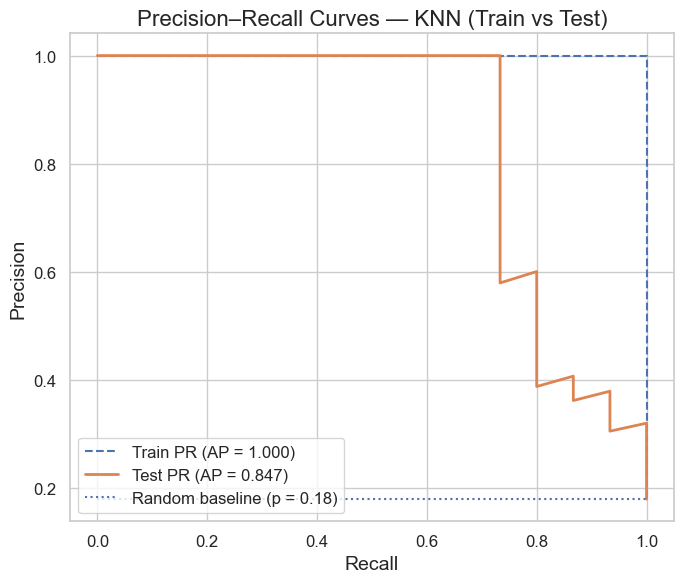

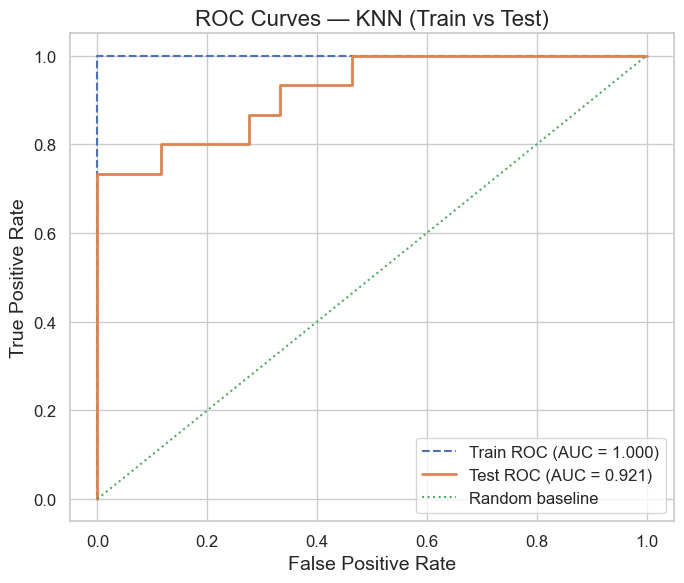

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# ---- Get predicted probabilities ----
train_proba = best_model.predict_proba(X_train)[:, 1]
test_proba  = best_model.predict_proba(X_test)[:, 1]

# ---- Precision–Recall curve points ----
precision_train, recall_train, _ = precision_recall_curve(y_train, train_proba)
precision_test,  recall_test,  _ = precision_recall_curve(y_test, test_proba)

# ---- PR AUC (Average Precision) ----
ap_train = average_precision_score(y_train, train_proba)
ap_test  = average_precision_score(y_test, test_proba)

# ---- Plot ----
plt.figure(figsize=(7, 6))

plt.plot(
    recall_train, precision_train,
    linestyle="--",
    label=f"Train PR (AP = {ap_train:.3f})"
)

plt.plot(
    recall_test, precision_test,
    linewidth=2,
    label=f"Test PR (AP = {ap_test:.3f})"
)

# Baseline: random classifier precision = prevalence
baseline = y_test.mean()
plt.hlines(
    baseline, xmin=0, xmax=1,
    linestyles=":",
    label=f"Random baseline (p = {baseline:.2f})"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — KNN (Train vs Test)")
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()

# ROC AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# ---- ROC curve points ----
fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
fpr_test,  tpr_test,  _ = roc_curve(y_test, test_proba)

# ---- ROC AUC values ----
auc_train = roc_auc_score(y_train, train_proba)
auc_test  = roc_auc_score(y_test, test_proba)

# ---- Plot ----
plt.figure(figsize=(7, 6))

plt.plot(
    fpr_train, tpr_train,
    linestyle="--",
    label=f"Train ROC (AUC = {auc_train:.3f})"
)

plt.plot(
    fpr_test, tpr_test,
    linewidth=2,
    label=f"Test ROC (AUC = {auc_test:.3f})"
)

# Random classifier baseline
plt.plot([0, 1], [0, 1], linestyle=":", label="Random baseline")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — KNN (Train vs Test)")
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()


### Down Sampling Result


===== TEST (balanced by downsampling) =====
Test Accuracy: 0.8666666666666667
Test Confusion matrix:
 [[15  0]
 [ 4 11]]
              precision    recall  f1-score   support

           0      0.789     1.000     0.882        15
           1      1.000     0.733     0.846        15

    accuracy                          0.867        30
   macro avg      0.895     0.867     0.864        30
weighted avg      0.895     0.867     0.864        30

Test PR AUC (Average Precision): 0.9265470439383483
Test ROC AUC (optional): 0.9022222222222221


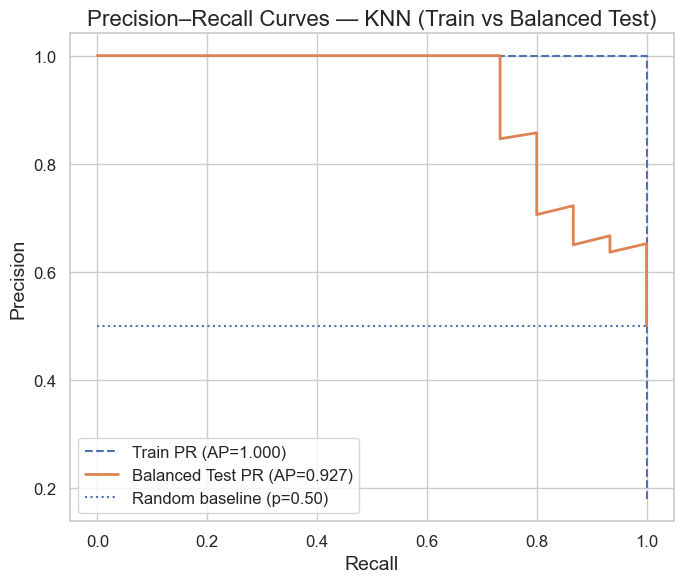

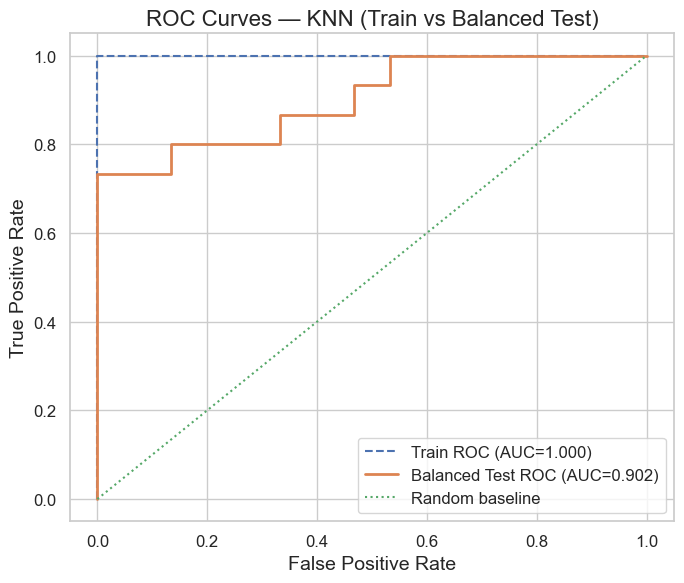

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    average_precision_score, precision_recall_curve,
    roc_auc_score, roc_curve
)

# -----------------------------
# Create ONE balanced test set (reproducible)
# -----------------------------
test_df = X_test.copy()
test_df["y"] = y_test.values

pos = test_df[test_df["y"] == 1]
neg = test_df[test_df["y"] == 0]

n = len(pos)
neg_sample = neg.sample(n=n, random_state=42)
pos_sample = pos.sample(n=n, random_state=42)

balanced_test = (
    pd.concat([neg_sample, pos_sample])
    .sample(frac=1, random_state=42)
)

X_test_bal = balanced_test.drop(columns=["y"])
y_test_bal = balanced_test["y"]

print("\n===== TEST (balanced by downsampling) =====")

test_pred_bal = best_model.predict(X_test_bal)
print("Test Accuracy:", accuracy_score(y_test_bal, test_pred_bal))
print("Test Confusion matrix:\n", confusion_matrix(y_test_bal, test_pred_bal))
print(classification_report(y_test_bal, test_pred_bal, digits=3))

test_proba_bal = best_model.predict_proba(X_test_bal)[:, 1]
print("Test PR AUC (Average Precision):",
      average_precision_score(y_test_bal, test_proba_bal))
print("Test ROC AUC (optional):", roc_auc_score(y_test_bal, test_proba_bal))

# -----------------------------
# PR curves: TRAIN vs BALANCED TEST
# -----------------------------
train_proba = best_model.predict_proba(X_train)[:, 1]

prec_train, rec_train, _ = precision_recall_curve(y_train, train_proba)
prec_test,  rec_test,  _ = precision_recall_curve(y_test_bal, test_proba_bal)

ap_train = average_precision_score(y_train, train_proba)
ap_test  = average_precision_score(y_test_bal, test_proba_bal)

plt.figure(figsize=(7, 6))
plt.plot(rec_train, prec_train, linestyle="--", label=f"Train PR (AP={ap_train:.3f})")
plt.plot(rec_test,  prec_test,  linewidth=2, label=f"Balanced Test PR (AP={ap_test:.3f})")

# baseline precision for balanced set is 0.5
plt.hlines(0.5, 0, 1, linestyles=":", label="Random baseline (p=0.50)")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — KNN (Train vs Balanced Test)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# ROC curves: TRAIN vs BALANCED TEST (optional)
# -----------------------------
fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
fpr_test,  tpr_test,  _ = roc_curve(y_test_bal, test_proba_bal)

auc_train = roc_auc_score(y_train, train_proba)
auc_test  = roc_auc_score(y_test_bal, test_proba_bal)

plt.figure(figsize=(7, 6))

plt.plot(
    fpr_train, tpr_train,
    linestyle="--",
    label=f"Train ROC (AUC={auc_train:.3f})"
)

plt.plot(
    fpr_test, tpr_test,
    linewidth=2,
    label=f"Balanced Test ROC (AUC={auc_test:.3f})"
)

plt.plot([0, 1], [0, 1], linestyle=":", label="Random baseline")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — KNN (Train vs Balanced Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## PCA Exploration

In [83]:
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

pipe_pca_knn = Pipeline(steps=[
    ("prep", preprocess),
    ("pca", "passthrough"),
    ("knn", KNeighborsClassifier(metric="minkowski"))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pca_options = ["passthrough"]

# Variance-retention PCA (common in practice)
for v in [0.85, 0.90, 0.93, 0.95, 0.97, 0.98, 0.99, 0.995]:
    pca_options.append(PCA(n_components=v, random_state=42, whiten=False))

# Fixed number of components (useful when thresholds jump)
for k in [5, 8, 10, 12, 15, 18, 20, 25]:
    pca_options.append(PCA(n_components=k, random_state=42, whiten=False))

# Whitening variants (optional, can help distance-based models)
for v in [0.95, 0.98, 0.99]:
    pca_options.append(PCA(n_components=v, random_state=42, whiten=True))
for k in [10, 15, 20]:
    pca_options.append(PCA(n_components=k, random_state=42, whiten=True))

param_grid = {
    "pca": pca_options,

    # neighborhood size: denser around small/medium + include larger smoothers
    "knn__n_neighbors": [3, 5, 7, 9, 11, 15, 21, 31, 41, 51, 61],

    "knn__weights": ["uniform", "distance"],

    # Minkowski p: L1 vs L2 (often enough)
    "knn__p": [1, 2],

    # mostly affects speed, but fast to include
    "knn__leaf_size": [10, 30, 50],
}

grid = GridSearchCV(
    pipe_pca_knn,
    param_grid=param_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)
print("Best CV PR AUC:", grid.best_score_)
print("Best params:", grid.best_params_)
best_model_pca_knn = grid.best_estimator_

Fitting 10 folds for each of 3036 candidates, totalling 30360 fits
Best CV PR AUC: 0.9150185925185925
Best params: {'knn__leaf_size': 10, 'knn__n_neighbors': 51, 'knn__p': 2, 'knn__weights': 'distance', 'pca': PCA(n_components=5, random_state=42)}


In [122]:
# -----------------------------
# Performance comparison: TRAIN vs TEST
# -----------------------------

# ---- TRAIN metrics ----
train_pred = best_model_pca_knn.predict(X_train)
print("\n===== TRAIN (on training data) =====")
print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Train Confusion matrix:\n", confusion_matrix(y_train, train_pred))
print(classification_report(y_train, train_pred, digits=3))

if hasattr(best_model_pca_knn, "predict_proba"):
    train_proba = best_model_pca_knn.predict_proba(X_train)[:, 1]
    print("Train PR AUC (Average Precision):", average_precision_score(y_train, train_proba))
    print("Train ROC AUC (optional):", roc_auc_score(y_train, train_proba))

# ---- TEST metrics ----
test_pred = best_model_pca_knn.predict(X_test)
print("\n===== TEST (held-out) =====")
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("Test Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

if hasattr(best_model_pca_knn, "predict_proba"):
    test_proba = best_model_pca_knn.predict_proba(X_test)[:, 1]
    print("Test PR AUC (Average Precision):", average_precision_score(y_test, test_proba))
    print("Test ROC AUC (optional):", roc_auc_score(y_test, test_proba))

# ---- CV std for best setting (PR AUC) ----
best_idx = grid.best_index_
print("\nBest setting CV PR AUC mean ± std:",
      f"{grid.cv_results_['mean_test_score'][best_idx]:.4f} ± {grid.cv_results_['std_test_score'][best_idx]:.4f}")

# ---- How many PCs were used if PCA is active ----
pca_step = best_model_pca_knn.named_steps["pca"]
if pca_step != "passthrough":
    print("\nPCA actually used.")
    print("Chosen n_components_:", pca_step.n_components_)
    print("Total explained variance:", pca_step.explained_variance_ratio_.sum())
else:
    print("\nNo PCA was used (passthrough).")


===== TRAIN (on training data) =====
Train Accuracy: 1.0
Train Confusion matrix:
 [[274   0]
 [  0  60]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       274
           1      1.000     1.000     1.000        60

    accuracy                          1.000       334
   macro avg      1.000     1.000     1.000       334
weighted avg      1.000     1.000     1.000       334

Train PR AUC (Average Precision): 1.0
Train ROC AUC (optional): 1.0

===== TEST (held-out) =====
Test Accuracy: 0.9404761904761905
Test Confusion matrix:
 [[69  0]
 [ 5 10]]
              precision    recall  f1-score   support

           0      0.932     1.000     0.965        69
           1      1.000     0.667     0.800        15

    accuracy                          0.940        84
   macro avg      0.966     0.833     0.883        84
weighted avg      0.944     0.940     0.936        84

Test PR AUC (Average Precision): 0.8508651621183589
Test ROC AUC (

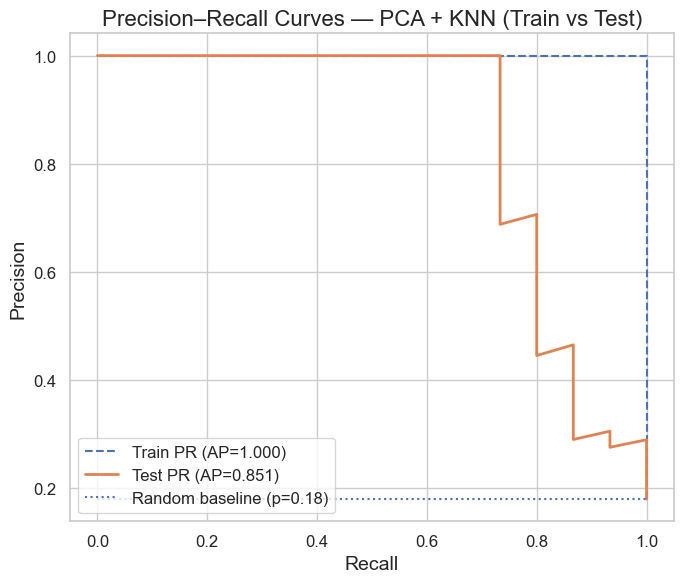

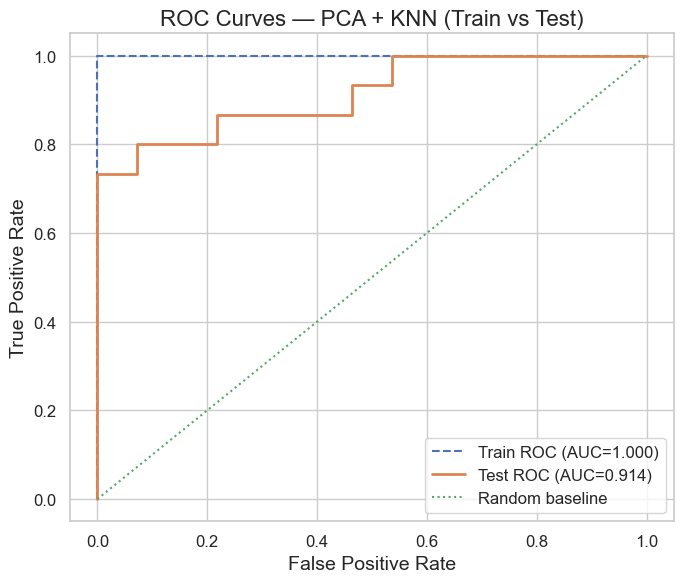

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    roc_auc_score, roc_curve
)

# After:
# grid.fit(X_train, y_train)
# best_model_pca_knn = grid.best_estimator_

# ---- Predicted probabilities ----
train_proba_pca = best_model_pca_knn.predict_proba(X_train)[:, 1]
test_proba_pca  = best_model_pca_knn.predict_proba(X_test)[:, 1]

# =============================
# PR AUC (Average Precision) + PR Curves
# =============================
prec_train, rec_train, _ = precision_recall_curve(y_train, train_proba_pca)
prec_test,  rec_test,  _ = precision_recall_curve(y_test,  test_proba_pca)

ap_train = average_precision_score(y_train, train_proba_pca)
ap_test  = average_precision_score(y_test,  test_proba_pca)

plt.figure(figsize=(7, 6))
plt.plot(rec_train, prec_train, linestyle="--", label=f"Train PR (AP={ap_train:.3f})")
plt.plot(rec_test,  prec_test,  linewidth=2, label=f"Test PR (AP={ap_test:.3f})")

# Baseline: random precision = prevalence on TEST
baseline = y_test.mean()
plt.hlines(baseline, 0, 1, linestyles=":", label=f"Random baseline (p={baseline:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — PCA + KNN (Train vs Test)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================
# ROC AUC + ROC Curves (optional)
# =============================
fpr_train, tpr_train, _ = roc_curve(y_train, train_proba_pca)
fpr_test,  tpr_test,  _ = roc_curve(y_test,  test_proba_pca)

auc_train = roc_auc_score(y_train, train_proba_pca)
auc_test  = roc_auc_score(y_test,  test_proba_pca)

plt.figure(figsize=(7, 6))
plt.plot(fpr_train, tpr_train, linestyle="--", label=f"Train ROC (AUC={auc_train:.3f})")
plt.plot(fpr_test,  tpr_test,  linewidth=2, label=f"Test ROC (AUC={auc_test:.3f})")
plt.plot([0, 1], [0, 1], linestyle=":", label="Random baseline")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — PCA + KNN (Train vs Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### Down Sampling Result


===== PCA + KNN — TRAIN (balanced by downsampling) =====
Train Accuracy: 1.0
Train Confusion matrix:
 [[60  0]
 [ 0 60]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        60
           1      1.000     1.000     1.000        60

    accuracy                          1.000       120
   macro avg      1.000     1.000     1.000       120
weighted avg      1.000     1.000     1.000       120

Train PR AUC (Average Precision): 1.0
Train ROC AUC (optional): 1.0

===== PCA + KNN — TEST (balanced by downsampling) =====
Test Accuracy: 0.8333333333333334
Test Confusion matrix:
 [[15  0]
 [ 5 10]]
              precision    recall  f1-score   support

           0      0.750     1.000     0.857        15
           1      1.000     0.667     0.800        15

    accuracy                          0.833        30
   macro avg      0.875     0.833     0.829        30
weighted avg      0.875     0.833     0.829        30

Test PR AUC (Average P

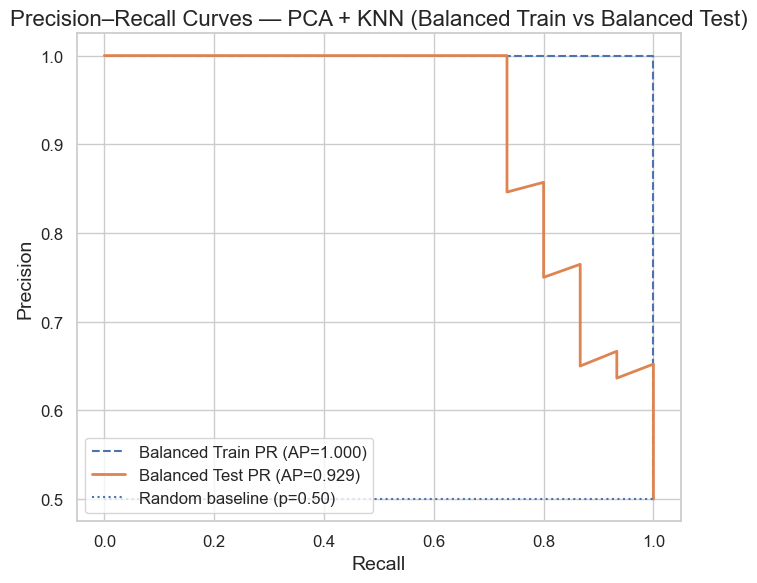

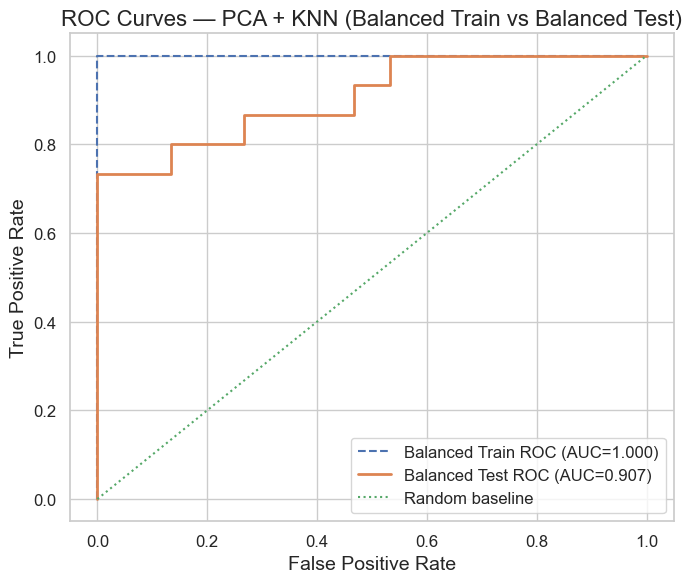

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    average_precision_score, precision_recall_curve,
    roc_auc_score, roc_curve
)

# =====================================================
# Helper: downsample to make a balanced dataset
# =====================================================
def make_balanced_downsample(X, y, random_state=42):
    df = X.copy()
    df["y"] = y.values if hasattr(y, "values") else y

    pos = df[df["y"] == 1]
    neg = df[df["y"] == 0]

    n = min(len(pos), len(neg))  # safety
    pos_sample = pos.sample(n=n, random_state=random_state)
    neg_sample = neg.sample(n=n, random_state=random_state)

    bal = (
        pd.concat([pos_sample, neg_sample])
        .sample(frac=1, random_state=random_state)
        .reset_index(drop=True)
    )
    X_bal = bal.drop(columns=["y"])
    y_bal = bal["y"]
    return X_bal, y_bal

# =====================================================
# Create ONE balanced TEST set (downsampling)
# =====================================================
X_test_bal, y_test_bal = make_balanced_downsample(X_test, y_test, random_state=42)

# =====================================================
# Create ONE balanced TRAIN set (downsampling)
# =====================================================
X_train_bal, y_train_bal = make_balanced_downsample(X_train, y_train, random_state=42)

# =====================================================
# Metrics on balanced TRAIN set (PCA model)
# =====================================================
print("\n===== PCA + KNN — TRAIN (balanced by downsampling) =====")

train_pred_bal = best_model_pca_knn.predict(X_train_bal)
print("Train Accuracy:", accuracy_score(y_train_bal, train_pred_bal))
print("Train Confusion matrix:\n", confusion_matrix(y_train_bal, train_pred_bal))
print(classification_report(y_train_bal, train_pred_bal, digits=3))

train_proba_bal = best_model_pca_knn.predict_proba(X_train_bal)[:, 1]
print("Train PR AUC (Average Precision):",
      average_precision_score(y_train_bal, train_proba_bal))
print("Train ROC AUC (optional):",
      roc_auc_score(y_train_bal, train_proba_bal))

# =====================================================
# Metrics on balanced TEST set (PCA model)
# =====================================================
print("\n===== PCA + KNN — TEST (balanced by downsampling) =====")

test_pred_bal = best_model_pca_knn.predict(X_test_bal)
print("Test Accuracy:", accuracy_score(y_test_bal, test_pred_bal))
print("Test Confusion matrix:\n", confusion_matrix(y_test_bal, test_pred_bal))
print(classification_report(y_test_bal, test_pred_bal, digits=3))

test_proba_bal = best_model_pca_knn.predict_proba(X_test_bal)[:, 1]
print("Test PR AUC (Average Precision):",
      average_precision_score(y_test_bal, test_proba_bal))
print("Test ROC AUC (optional):",
      roc_auc_score(y_test_bal, test_proba_bal))

# =====================================================
# keep FULL TRAIN probabilities
# =====================================================
train_proba_full = best_model_pca_knn.predict_proba(X_train)[:, 1]

# =====================================================
# Precision–Recall curves (BAL TRAIN vs BAL TEST)
# =====================================================
prec_train_bal, rec_train_bal, _ = precision_recall_curve(y_train_bal, train_proba_bal)
prec_test_bal,  rec_test_bal,  _ = precision_recall_curve(y_test_bal,  test_proba_bal)

ap_train_bal = average_precision_score(y_train_bal, train_proba_bal)
ap_test_bal  = average_precision_score(y_test_bal,  test_proba_bal)

plt.figure(figsize=(7, 6))
plt.plot(rec_train_bal, prec_train_bal, linestyle="--",
         label=f"Balanced Train PR (AP={ap_train_bal:.3f})")
plt.plot(rec_test_bal, prec_test_bal, linewidth=2,
         label=f"Balanced Test PR (AP={ap_test_bal:.3f})")

# baseline precision for a balanced set = 0.5
plt.hlines(0.5, 0, 1, linestyles=":", label="Random baseline (p=0.50)")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — PCA + KNN (Balanced Train vs Balanced Test)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================================
# ROC curves (BAL TRAIN vs BAL TEST)
# =====================================================
fpr_train_bal, tpr_train_bal, _ = roc_curve(y_train_bal, train_proba_bal)
fpr_test_bal,  tpr_test_bal,  _ = roc_curve(y_test_bal,  test_proba_bal)

auc_train_bal = roc_auc_score(y_train_bal, train_proba_bal)
auc_test_bal  = roc_auc_score(y_test_bal,  test_proba_bal)

plt.figure(figsize=(7, 6))
plt.plot(fpr_train_bal, tpr_train_bal, linestyle="--",
         label=f"Balanced Train ROC (AUC={auc_train_bal:.3f})")
plt.plot(fpr_test_bal, tpr_test_bal, linewidth=2,
         label=f"Balanced Test ROC (AUC={auc_test_bal:.3f})")

plt.plot([0, 1], [0, 1], linestyle=":", label="Random baseline")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — PCA + KNN (Balanced Train vs Balanced Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Threshold Adjusting

CV (OOF) Average Precision = 0.908


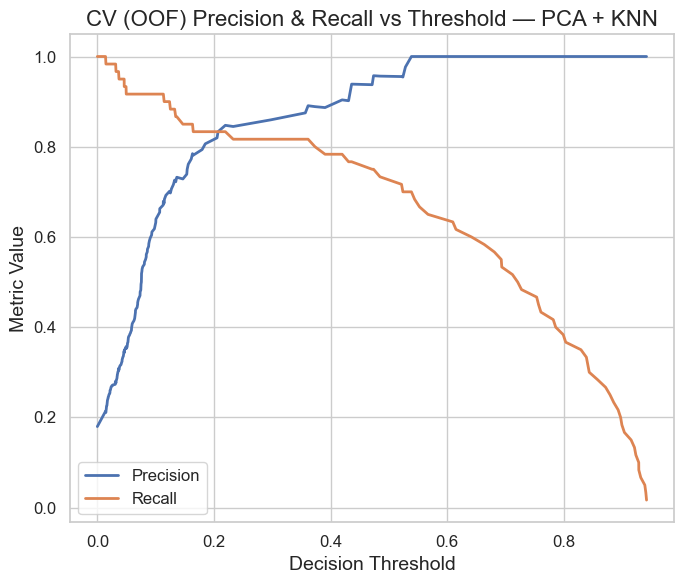

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_curve, average_precision_score

# --------------------------------------------
# Get CV out-of-fold probabilities
# --------------------------------------------

# 10-fold CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Out-of-fold predicted probabilities for the positive class
# IMPORTANT: best_model_pca_knn should be an unfitted estimator/pipeline
# (or at least a cloneable sklearn estimator)
oof_proba = cross_val_predict(
    best_model_pca_knn,
    X_train,
    y_train,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# --------------------------------------------
# Compute precision, recall for all thresholds
# --------------------------------------------
precision, recall, thresholds = precision_recall_curve(y_train, oof_proba)
ap = average_precision_score(y_train, oof_proba)
print(f"CV (OOF) Average Precision = {ap:.3f}")

# --------------------------------------------
# Plot Precision & Recall vs Threshold
# --------------------------------------------
plt.figure(figsize=(7, 6))
plt.plot(thresholds, precision[:-1], label="Precision", linewidth=2)
plt.plot(thresholds, recall[:-1], label="Recall", linewidth=2)

plt.xlabel("Decision Threshold")
plt.ylabel("Metric Value")
plt.title("CV (OOF) Precision & Recall vs Threshold — PCA + KNN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------

In [129]:
# --------------------------------------------
# Find threshold where Precision = Recall
# and compute Precision & Recall at that point
# --------------------------------------------

p = precision[:-1]   # align with thresholds
r = recall[:-1]
t = thresholds

diff = p - r

# Find where the sign changes (intersection)
idx = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0]

if len(idx) == 0:
    # No exact crossing → take closest point
    j = np.argmin(np.abs(diff))
    t_intersect = t[j]
    p_intersect = p[j]
    r_intersect = r[j]

    print("No exact intersection found.")
    print(f"Closest point:")
    print(f"  threshold ≈ {t_intersect:.4f}")
    print(f"  precision ≈ {p_intersect:.4f}")
    print(f"  recall    ≈ {r_intersect:.4f}")
else:
    # Take the first intersection
    i = idx[0]

    # Linear interpolation to estimate intersection threshold
    t0, t1 = t[i], t[i + 1]
    d0, d1 = diff[i], diff[i + 1]

    t_intersect = t0 + (0 - d0) * (t1 - t0) / (d1 - d0)

    # Linear interpolation for precision & recall
    p_intersect = p[i] + (t_intersect - t0) * (p[i + 1] - p[i]) / (t1 - t0)
    r_intersect = r[i] + (t_intersect - t0) * (r[i + 1] - r[i]) / (t1 - t0)

    print("Intersection found:")
    print(f"  threshold ≈ {t_intersect:.4f}")
    print(f"  precision ≈ {p_intersect:.4f}")
    print(f"  recall    ≈ {r_intersect:.4f}")


Intersection found:
  threshold ≈ 0.2070
  precision ≈ 0.8333
  recall    ≈ 0.8333


Interpolated threshold for recall = 0.8333: 0.2196
Interpolated precision at that threshold: 0.847


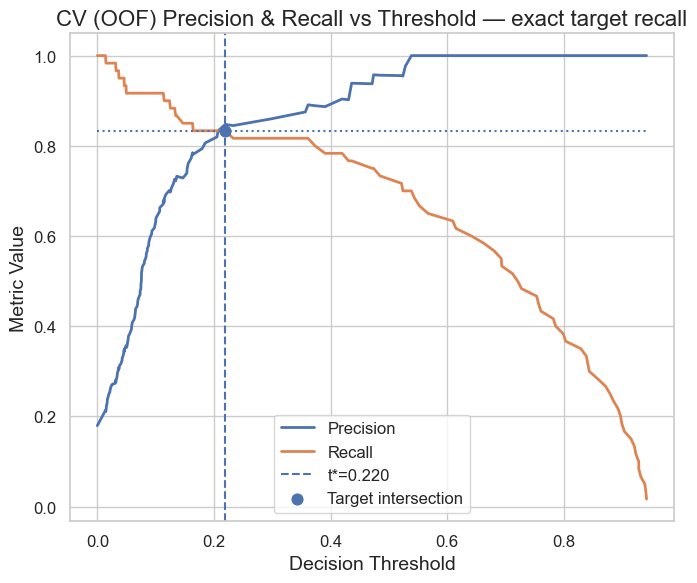

In [167]:
# Recompute PR curve to guarantee aligned arrays
precision, recall, thr_pr = precision_recall_curve(y_train, oof_proba)

target_recall = 0.8333
# target_recall = 0.915

p = precision[:-1]
r = recall[:-1]
t = thr_pr

# print("Lengths:", len(precision), len(recall), len(t))  # should be N, N, N-1

# Find where recall crosses target (from >= to <)
cross = np.where((r[:-1] >= target_recall) & (r[1:] < target_recall))[0]

if len(cross) == 0:
    print("Target recall not achievable or recall never crosses it.")
else:
    i = cross[0]  # interval [i, i+1]

    r0, r1 = r[i], r[i+1]
    t0, t1 = t[i], t[i+1]

    # Interpolate threshold t_star where recall == target_recall
    if r1 == r0:
        t_star = t0
    else:
        t_star = t0 + (target_recall - r0) * (t1 - t0) / (r1 - r0)

    # Interpolate precision at t_star
    p0, p1 = p[i], p[i+1]
    p_star = p0 + (t_star - t0) * (p1 - p0) / (t1 - t0)

    print(f"Interpolated threshold for recall = {target_recall:.4f}: {t_star:.4f}")
    print(f"Interpolated precision at that threshold: {p_star:.3f}")

    import matplotlib.pyplot as plt
    plt.figure(figsize=(7, 6))
    plt.plot(t, p, label="Precision", linewidth=2)
    plt.plot(t, r, label="Recall", linewidth=2)

    plt.axvline(t_star, linestyle="--", label=f"t*={t_star:.3f}")
    plt.hlines(target_recall, t.min(), t.max(), linestyles=":")

    plt.scatter([t_star], [target_recall], s=60, zorder=5, label="Target intersection")

    plt.xlabel("Decision Threshold")
    plt.ylabel("Metric Value")
    plt.title("CV (OOF) Precision & Recall vs Threshold — exact target recall")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Evaluation

In [168]:
# -----------------------------
# Imports
# -----------------------------
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    average_precision_score, roc_auc_score
)

# THRESHOLD = 0.1132
THRESHOLD = 0.2196

# =====================================================
# TRAIN metrics using CV out-of-fold probabilities
# =====================================================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Out-of-fold probabilities for every training point
oof_proba = cross_val_predict(
    best_model_pca_knn,
    X_train,
    y_train,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

oof_pred = (oof_proba >= THRESHOLD).astype(int)

print("\n===== TRAIN (CV out-of-fold) =====")
print("Train Accuracy:", accuracy_score(y_train, oof_pred))
print("Train Confusion matrix:\n", confusion_matrix(y_train, oof_pred))
print(classification_report(y_train, oof_pred, digits=3))

print("Train PR AUC (Average Precision):",
      average_precision_score(y_train, oof_proba))
print("Train ROC AUC (optional):",
      roc_auc_score(y_train, oof_proba))

# =====================================================
# CV PR AUC mean ± std (fold-averaged, GridSearchCV style)
# =====================================================
fold_pr_auc = []

for tr_idx, va_idx in cv.split(X_train, y_train):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    model = clone(best_model_pca_knn)
    model.fit(X_tr, y_tr)

    proba_va = model.predict_proba(X_va)[:, 1]
    fold_pr_auc.append(average_precision_score(y_va, proba_va))

print(f"\nBest setting CV PR AUC mean ± std: "
      f"{np.mean(fold_pr_auc):.4f} ± {np.std(fold_pr_auc, ddof=1):.4f}")

# =====================================================
# TEST metrics: single held-out evaluation (same threshold)
# =====================================================
test_proba = best_model_pca_knn.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= THRESHOLD).astype(int)

print("\n===== TEST (held-out) =====")
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("Test Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

print("Test PR AUC (Average Precision):",
      average_precision_score(y_test, test_proba))
print("Test ROC AUC (optional):",
      roc_auc_score(y_test, test_proba))



===== TRAIN (CV out-of-fold) =====
Train Accuracy: 0.9401197604790419
Train Confusion matrix:
 [[265   9]
 [ 11  49]]
              precision    recall  f1-score   support

           0      0.960     0.967     0.964       274
           1      0.845     0.817     0.831        60

    accuracy                          0.940       334
   macro avg      0.902     0.892     0.897       334
weighted avg      0.939     0.940     0.940       334

Train PR AUC (Average Precision): 0.9078108844327336
Train ROC AUC (optional): 0.9484184914841849

Best setting CV PR AUC mean ± std: 0.9150 ± 0.0594

===== TEST (held-out) =====
Test Accuracy: 0.8928571428571429
Test Confusion matrix:
 [[63  6]
 [ 3 12]]
              precision    recall  f1-score   support

           0      0.955     0.913     0.933        69
           1      0.667     0.800     0.727        15

    accuracy                          0.893        84
   macro avg      0.811     0.857     0.830        84
weighted avg      0.903   

#### Stability Check

In [142]:
import numpy as np
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_score, recall_score
)

# =====================================================
# Uncertainty / stability on TEST via bootstrap CIs
#   - Works well when positives are small (e.g., 15)
#   - Reports 95% CI for PR AUC, ROC AUC, Precision, Recall
# =====================================================

THRESHOLD = 0.1132
B = 5000          # bootstrap reps (e.g., 2000–10000)
SEED = 42
ALPHA = 0.05      # 95% CI

rng = np.random.default_rng(SEED)

# probabilities + thresholded predictions on the held-out test set
test_proba = best_model_pca_knn.predict_proba(X_test)[:, 1]
test_pred  = (test_proba >= THRESHOLD).astype(int)

y_true = np.asarray(y_test)

def safe_roc_auc(y, s):
    # ROC AUC undefined if only one class appears in a resample
    if len(np.unique(y)) < 2:
        return np.nan
    return roc_auc_score(y, s)

def bootstrap_ci(metric_fn, y, pred=None, score=None, B=2000, alpha=0.05):
    vals = []
    n = len(y)
    for _ in range(B):
        idx = rng.integers(0, n, size=n)   # sample with replacement
        y_b = y[idx]
        pred_b = pred[idx] if pred is not None else None
        score_b = score[idx] if score is not None else None

        v = metric_fn(y_b, pred_b, score_b)
        vals.append(v)

    vals = np.asarray(vals, dtype=float)
    vals = vals[~np.isnan(vals)]  # drop undefined (mainly ROC AUC edge cases)

    lo = np.quantile(vals, alpha / 2)
    hi = np.quantile(vals, 1 - alpha / 2)
    return vals.mean(), lo, hi

# Metric wrappers
pr_auc_fn = lambda y, pred, score: average_precision_score(y, score)
roc_auc_fn = lambda y, pred, score: safe_roc_auc(y, score)
prec_fn   = lambda y, pred, score: precision_score(y, pred, zero_division=0)
rec_fn    = lambda y, pred, score: recall_score(y, pred, zero_division=0)

# Point estimates
point_pr  = average_precision_score(y_true, test_proba)
point_roc = roc_auc_score(y_true, test_proba)
point_prec = precision_score(y_true, test_pred, zero_division=0)
point_rec  = recall_score(y_true, test_pred, zero_division=0)

# Bootstrap CIs
pr_mean, pr_lo, pr_hi = bootstrap_ci(pr_auc_fn,  y_true, score=test_proba, B=B, alpha=ALPHA)
roc_mean, roc_lo, roc_hi = bootstrap_ci(roc_auc_fn, y_true, score=test_proba, B=B, alpha=ALPHA)
prec_mean, prec_lo, prec_hi = bootstrap_ci(prec_fn, y_true, pred=test_pred, B=B, alpha=ALPHA)
rec_mean, rec_lo, rec_hi = bootstrap_ci(rec_fn,  y_true, pred=test_pred, B=B, alpha=ALPHA)

print("\n===== TEST stability (bootstrap 95% CI) =====")
print(f"Threshold used: {THRESHOLD:.4f}")
print(f"PR AUC  : {point_pr:.4f}  (95% CI: {pr_lo:.4f}, {pr_hi:.4f})")
print(f"ROC AUC : {point_roc:.4f}  (95% CI: {roc_lo:.4f}, {roc_hi:.4f})")
print(f"Precision@t: {point_prec:.4f}  (95% CI: {prec_lo:.4f}, {prec_hi:.4f})")
print(f"Recall@t   : {point_rec:.4f}  (95% CI: {rec_lo:.4f}, {rec_hi:.4f})")



===== TEST stability (bootstrap 95% CI) =====
Threshold used: 0.1132
PR AUC  : 0.8509  (95% CI: 0.6715, 0.9810)
ROC AUC : 0.9140  (95% CI: 0.8028, 0.9947)
Precision@t: 0.5217  (95% CI: 0.3158, 0.7333)
Recall@t   : 0.8000  (95% CI: 0.5714, 1.0000)


#### Calibration

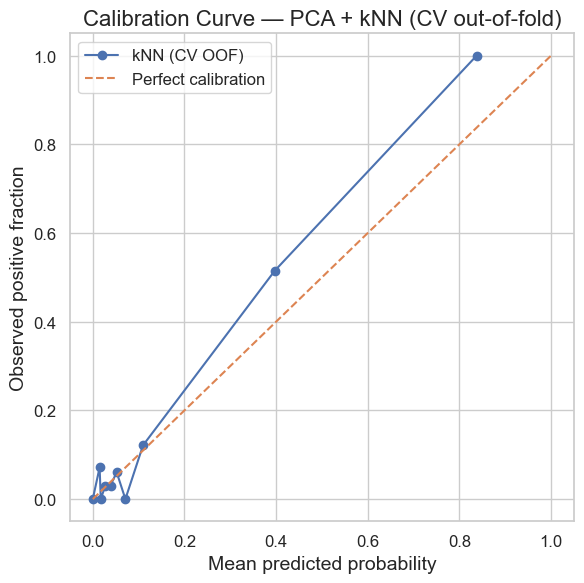

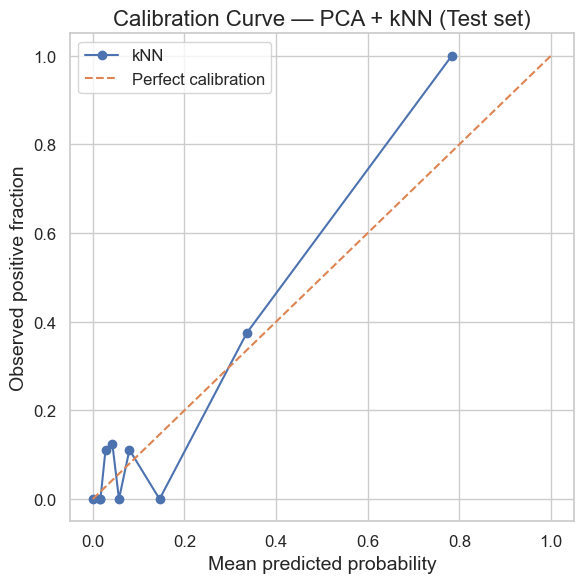

Test Brier score: 0.0609


In [145]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Predicted probabilities (TEST set)
test_proba = best_model_pca_knn.predict_proba(X_test)[:, 1]

# Using oof_proba from earlier
frac_pos_cv, mean_pred_cv = calibration_curve(
    y_train,
    oof_proba,
    n_bins=10,
    strategy="quantile"
)

plt.figure(figsize=(6, 6))
plt.plot(mean_pred_cv, frac_pos_cv, marker="o", label="kNN (CV OOF)")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")

plt.xlabel("Mean predicted probability")
plt.ylabel("Observed positive fraction")
plt.title("Calibration Curve — PCA + kNN (CV out-of-fold)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calibration curve
frac_pos, mean_pred = calibration_curve(
    y_test,
    test_proba,
    n_bins=10,
    strategy="quantile"   # IMPORTANT: use quantile for small datasets
)

plt.figure(figsize=(6, 6))
plt.plot(mean_pred, frac_pos, marker="o", label="kNN")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")

plt.xlabel("Mean predicted probability")
plt.ylabel("Observed positive fraction")
plt.title("Calibration Curve — PCA + kNN (Test set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

brier = brier_score_loss(y_test, test_proba)
print(f"Test Brier score: {brier:.4f}")



#### Error Analysis

In [152]:
# =====================================================
# Error analysis (TEST set): false negatives + high-confidence mistakes
# =====================================================
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix

THRESHOLD = 0.2196

# ---- 1) Get probs + predictions on TEST ----
test_proba = best_model_pca_knn.predict_proba(X_test)[:, 1]
test_pred  = (test_proba >= THRESHOLD).astype(int)

# Work in a single dataframe for easy filtering
err_df = X_test.copy()
err_df = err_df.reset_index(drop=True)   # clean indexing
y_test_reset = pd.Series(y_test).reset_index(drop=True)

err_df["y_true"] = y_test_reset
err_df["p_hat"]  = test_proba
err_df["y_pred"] = test_pred
err_df["error_type"] = np.select(
    [
        (err_df["y_true"] == 1) & (err_df["y_pred"] == 0),  # FN
        (err_df["y_true"] == 0) & (err_df["y_pred"] == 1),  # FP
        (err_df["y_true"] == 0) & (err_df["y_pred"] == 0),  # TN
        (err_df["y_true"] == 1) & (err_df["y_pred"] == 1),  # TP
    ],
    ["FN", "FP", "TN", "TP"],
    default="UNK"
)

print("\n===== Error counts on TEST (thresholded) =====")
print(err_df["error_type"].value_counts())

# ---- 2) False negatives table (missed cancers) ----
false_neg = err_df[err_df["error_type"] == "FN"].copy()

print("\n===== FALSE NEGATIVES (missed cancers) =====")
print(false_neg[["p_hat"]].describe())

# If there is a clinic/site column, put it here (adjust name):
# e.g. SITE_COL = "clinic_id" or "site"
SITE_COL = None  # <-- set to column name if it exists, e.g. "clinic_id"

if SITE_COL is not None and SITE_COL in false_neg.columns:
    print(f"\nFalse negatives by {SITE_COL}:")
    print(false_neg[SITE_COL].value_counts(dropna=False).head(20))

# ---- 3) Missingness patterns: compare FN vs others ----
# Missing count per row (how many NaNs)
feature_cols = [c for c in err_df.columns if c not in ["y_true", "p_hat", "y_pred", "error_type"]]
err_df["n_missing"] = err_df[feature_cols].isna().sum(axis=1)
err_df["missing_rate"] = err_df["n_missing"] / len(feature_cols)

# ---- Refresh FN/FP after adding missingness columns ----
false_neg = err_df[err_df["error_type"] == "FN"].copy()
false_pos = err_df[err_df["error_type"] == "FP"].copy()

top_fn = false_neg.sort_values("p_hat", ascending=True).head(10)
top_fp = false_pos.sort_values("p_hat", ascending=False).head(10)


print("\n===== Missingness summary (TEST) =====")
print("Overall missing_rate:", err_df["missing_rate"].describe())
print("FN missing_rate:", false_neg["missing_rate"].describe() if "missing_rate" in false_neg else "N/A")

# Compare average missingness by error type
missing_by_type = err_df.groupby("error_type")[["n_missing", "missing_rate"]].mean().sort_values("missing_rate", ascending=False)
print("\nAverage missingness by outcome type:")
print(missing_by_type)

# Identify features with unusually high missingness among FNs
# (fraction missing within FN group minus overall fraction missing)
overall_miss = err_df[feature_cols].isna().mean()
fn_miss = false_neg[feature_cols].isna().mean() if len(false_neg) > 0 else overall_miss

miss_gap = (fn_miss - overall_miss).sort_values(ascending=False)
print("\nTop features more-missing in FNs vs overall (FN_missing - overall_missing):")
print(miss_gap.head(15))

# ---- 4) Highest-confidence mistakes ----
# "High-confidence" means the model was very sure but wrong.
# For negatives predicted positive with high p_hat (FPs), p_hat close to 1.
# For positives predicted negative (FNs), p_hat close to 0.
false_pos = err_df[err_df["error_type"] == "FP"].copy()

# Sort FNs by lowest predicted probability (most confidently negative)
top_fn = false_neg.sort_values("p_hat", ascending=True).head(10)
# Sort FPs by highest predicted probability (most confidently positive)
top_fp = false_pos.sort_values("p_hat", ascending=False).head(10)

# ---- Safe printing (only keep columns that exist) ----
cols_show = ["p_hat", "n_missing", "missing_rate"]
if SITE_COL is not None and SITE_COL in err_df.columns:
    cols_show = [SITE_COL] + cols_show

cols_show = [c for c in cols_show if c in err_df.columns]  # keep existing only

print("\n===== Top 10 highest-confidence FALSE NEGATIVES (lowest p_hat) =====")
print(top_fn[cols_show].to_string(index=False))

print("\n===== Top 10 highest-confidence FALSE POSITIVES (highest p_hat) =====")
print(top_fp[cols_show].to_string(index=False))


# export for slide/table
# top_fn.to_csv("top_false_negatives.csv", index=False)
# top_fp.to_csv("top_false_positives.csv", index=False)

# ---- 5) Simple “what does the model miss?” numeric comparison (FN vs TP/overall) ----
# Compare feature means between FNs and TPs (only numeric columns, ignoring NaNs)
numeric_cols = err_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

tp_df = err_df[err_df["error_type"] == "TP"]
if len(false_neg) > 0 and len(tp_df) > 0 and len(numeric_cols) > 0:
    fn_means = false_neg[numeric_cols].mean(numeric_only=True)
    tp_means = tp_df[numeric_cols].mean(numeric_only=True)

    # Raw mean difference
    raw_diff = fn_means - tp_means

    # Relative difference (a.k.a. relative error vs TP mean)
    # Use abs(TP mean) to keep the scale meaningful and avoid division-by-zero
    denom = tp_means.abs().replace(0, np.nan)
    rel_diff = raw_diff / denom

    # Build summary table
    diff_table = pd.DataFrame({
        "raw_diff (FN-TP)": raw_diff,
        "relative_diff (FN-TP)": rel_diff
    })

    # Rank by magnitude of relative difference (scale-free ranking)
    diff_table = diff_table.sort_values(
        by="relative_diff (FN-TP)",
        key=lambda s: s.abs(),
        ascending=False
    )

    print("\nTop numeric feature mean differences (FN - TP) with relative difference:")
    # show top 15; format relative diff as percent for readability
    out = diff_table.head(15).copy()
    out["relative_diff (FN-TP)"] = (out["relative_diff (FN-TP)"] * 100).round(1).astype(str) + r"\%"
    print(out.to_string())
else:
    print("\nNot enough FN/TP or numeric features to compute mean-diff summary.")




===== Error counts on TEST (thresholded) =====
error_type
TN    63
TP    12
FP     6
FN     3
Name: count, dtype: int64

===== FALSE NEGATIVES (missed cancers) =====
          p_hat
count  3.000000
mean   0.055522
std    0.028721
min    0.035537
25%    0.039065
50%    0.042594
75%    0.065514
max    0.088435

===== Missingness summary (TEST) =====
Overall missing_rate: count    84.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: missing_rate, dtype: float64
FN missing_rate: count    3.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: missing_rate, dtype: float64

Average missingness by outcome type:
            n_missing  missing_rate
error_type                         
FN                0.0           0.0
FP                0.0           0.0
TN                0.0           0.0
TP                0.0           0.0

Top features more-missing in FNs vs overall (FN_missing - overall_mis

## Correlation Pruning + LDA

In [77]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# ============================================================
# 1) Column detection helpers
# ============================================================
def detect_binary_cols(df: pd.DataFrame):
    bin_cols = []
    for c in df.columns:
        if not np.issubdtype(df[c].dtype, np.number):
            continue
        vals = df[c].dropna().unique()
        if len(vals) == 2 and set(vals).issubset({0, 1}):
            bin_cols.append(c)
    return bin_cols

def detect_nonneg_skew_cols(df: pd.DataFrame, exclude_cols, skew_thresh=1.0):
    cols = []
    num_df = df.select_dtypes(include=[np.number])
    for c in num_df.columns:
        if c in exclude_cols:
            continue
        if num_df[c].min(skipna=True) >= 0:
            sk = num_df[c].skew()
            if np.isfinite(sk) and abs(sk) > skew_thresh:
                cols.append(c)
    return cols

def detect_other_continuous_cols(df: pd.DataFrame, exclude_cols):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in num_cols if c not in exclude_cols]

binary_cols = detect_binary_cols(X_train)
log_cols = detect_nonneg_skew_cols(X_train, exclude_cols=binary_cols, skew_thresh=1.0)
other_cont_cols = detect_other_continuous_cols(X_train, exclude_cols=binary_cols + log_cols)

print("Binary cols:", binary_cols)
print("Log1p cols:", log_cols)
print("Yeo-Johnson cols:", other_cont_cols)

# ============================================================
# 2) Correlation pruner (applied ONLY to continuous block)
# ============================================================
class CorrelationPruner(BaseEstimator, TransformerMixin):
    """
    Drops continuous features that are highly correlated with earlier features.
    Uses absolute Pearson correlation. Intended for already-scaled continuous data.
    """
    def __init__(self, threshold=0.95):
        self.threshold = float(threshold)

    def fit(self, X, y=None):
        X_arr = np.asarray(X)
        if X_arr.ndim == 1:
            X_arr = X_arr.reshape(-1, 1)

        d = X_arr.shape[1]
        if d <= 1:
            self.keep_mask_ = np.ones(d, dtype=bool)
            return self

        corr = np.corrcoef(X_arr, rowvar=False)
        corr = np.nan_to_num(corr, nan=0.0)
        abs_corr = np.abs(corr)

        keep = np.ones(d, dtype=bool)
        for j in range(d):
            if not keep[j]:
                continue
            for i in range(j + 1, d):
                if keep[i] and abs_corr[j, i] > self.threshold:
                    keep[i] = False

        self.keep_mask_ = keep
        return self

    def transform(self, X):
        X_arr = np.asarray(X)
        if X_arr.ndim == 1:
            X_arr = X_arr.reshape(-1, 1)
        return X_arr[:, self.keep_mask_]

# ============================================================
# 3) Build two separate blocks:
#    A) Binary clinic block: passthrough OR LDA(n_components=1)
#    B) Continuous block: transforms + scaling + correlation pruning
# ============================================================
log1p_tf = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

# --- Binary block options (handled via GridSearch on 'prep__bin') ---
# IMPORTANT: LDA is supervised; in a Pipeline it will be fit correctly inside CV folds.
bin_passthrough = "passthrough"
bin_lda = LinearDiscriminantAnalysis(n_components=1)

# --- Continuous preprocessing (no correlation pruning here yet) ---
cont_preprocess = ColumnTransformer(
    transformers=[
        ("log1p", Pipeline([("log", log1p_tf), ("sc", StandardScaler())]), log_cols),
        ("yj", Pipeline([("pt", PowerTransformer(method="yeo-johnson")),
                         ("sc", StandardScaler())]), other_cont_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# --- Continuous pipeline: preprocess -> correlation pruning ---
cont_pipe = Pipeline(steps=[
    ("cont_prep", cont_preprocess),
    ("corr", CorrelationPruner(threshold=0.95))  # threshold tuned by GridSearch
])

# ============================================================
# 4) Combined preprocessing:
#    - bin branch outputs either raw binaries OR 1D LDA score
#    - cont branch outputs transformed + scaled + pruned continuous features
# ============================================================
preprocess_two_branch = ColumnTransformer(
    transformers=[
        ("bin", bin_passthrough, binary_cols),   # will be switched to LDA in grid
        ("cont", cont_pipe, log_cols + other_cont_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ============================================================
# 5) Final pipeline: preprocess -> KNN
# ============================================================
pipe = Pipeline(steps=[
    ("prep", preprocess_two_branch),
    ("knn", KNeighborsClassifier(metric="minkowski"))
])

# ============================================================
# 6) Grid search over:
#    - whether to use LDA on binary clinic features
#    - correlation pruning threshold (continuous only)
#    - KNN hyperparameters
# ============================================================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

bin_options = ["passthrough"]
if len(binary_cols) > 0:
    bin_options.append(LinearDiscriminantAnalysis(n_components=1))

param_grid = {
    # LDA only for binary clinic features
    "prep__bin": bin_options,

    # Correlation pruning only for continuous features
    "prep__cont__corr__threshold": [0.7, 0.8, 0.85, 0.90, 0.95, 0.98],

    # KNN hyperparameters
    "knn__n_neighbors": [3, 5, 7, 9, 11, 15, 21, 31, 41, 51],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
    "knn__leaf_size": [10, 30, 50],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="average_precision",   # PR AUC
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("\nBest CV score (mean CV PR AUC):", grid.best_score_)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_


Binary cols: []
Log1p cols: ['mean radius', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst symmetry', 'worst fractal dimension']
Yeo-Johnson cols: ['mean texture', 'mean smoothness', 'mean symmetry', 'concave points error', 'worst texture', 'worst smoothness', 'worst concave points', 'severity_score']
Fitting 10 folds for each of 720 candidates, totalling 7200 fits

Best CV score (mean CV PR AUC): 0.9085690278535303
Best params: {'knn__leaf_size': 10, 'knn__n_neighbors': 41, 'knn__p': 1, 'knn__weights': 'distance', 'prep__bin': 'passthrough', 'prep__cont__corr__threshold': 0.98}


In [150]:
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,          # optional
    accuracy_score,
    classification_report,
    confusion_matrix
)

# already ran:
# best_model = grid.best_estimator_
# where best_model is the corr-pruning + (optional) LDA-on-binary + KNN pipeline.

# -----------------------------
# Performance comparison: TRAIN vs TEST
# -----------------------------

# ---- TRAIN metrics ----
train_pred = best_model.predict(X_train)
print("\n===== TRAIN (on training data) =====")
print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Train Confusion matrix:\n", confusion_matrix(y_train, train_pred))
print(classification_report(y_train, train_pred, digits=3))

if hasattr(best_model, "predict_proba"):
    train_proba = best_model.predict_proba(X_train)[:, 1]
    print("Train PR AUC (Average Precision):", average_precision_score(y_train, train_proba))
    print("Train ROC AUC (optional):", roc_auc_score(y_train, train_proba))

# ---- TEST metrics ----
test_pred = best_model.predict(X_test)
print("\n===== TEST (held-out) =====")
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("Test Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

if hasattr(best_model, "predict_proba"):
    test_proba = best_model.predict_proba(X_test)[:, 1]
    print("Test PR AUC (Average Precision):", average_precision_score(y_test, test_proba))
    print("Test ROC AUC (optional):", roc_auc_score(y_test, test_proba))

# ---- CV std for best setting (PR AUC) ----
best_idx = grid.best_index_
print("\nBest setting CV PR AUC mean ± std:",
      f"{grid.cv_results_['mean_test_score'][best_idx]:.4f} ± {grid.cv_results_['std_test_score'][best_idx]:.4f}")

# -----------------------------
# Model diagnostics: LDA + correlation pruning
# -----------------------------
# LDA usage on binary features
bin_step = best_model.named_steps["prep"].named_transformers_.get("bin", None)
if bin_step is None:
    print("\n[Diag] No 'bin' branch found in preprocess.")
else:
    if bin_step == "passthrough":
        print("\n[Diag] Binary clinic features used as-is (passthrough).")
    else:
        # likely LinearDiscriminantAnalysis
        print("\n[Diag] Binary clinic features were compressed using LDA.")
        if hasattr(bin_step, "scalings_"):
            # For binary classification, output should be 1D
            print("[Diag] LDA output dimension (expected 1 for binary y):",
                  1)

# Correlation pruning details (continuous-only branch)
cont_branch = best_model.named_steps["prep"].named_transformers_.get("cont", None)
if cont_branch is None:
    print("\n[Diag] No 'cont' branch found in preprocess.")
else:
    # cont branch is a Pipeline: cont_prep -> corr
    if hasattr(cont_branch, "named_steps") and "corr" in cont_branch.named_steps:
        corr_step = cont_branch.named_steps["corr"]
        if hasattr(corr_step, "threshold"):
            print("\n[Diag] Correlation pruning threshold:", corr_step.threshold)
        if hasattr(corr_step, "keep_mask_"):
            kept = int(np.sum(corr_step.keep_mask_))
            total = int(len(corr_step.keep_mask_))
            print(f"[Diag] Continuous features kept after pruning: {kept}/{total}")
    else:
        print("\n[Diag] Continuous branch does not contain a 'corr' step.")



===== TRAIN (on training data) =====
Train Accuracy: 1.0
Train Confusion matrix:
 [[274   0]
 [  0  60]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       274
           1      1.000     1.000     1.000        60

    accuracy                          1.000       334
   macro avg      1.000     1.000     1.000       334
weighted avg      1.000     1.000     1.000       334

Train PR AUC (Average Precision): 1.0
Train ROC AUC (optional): 1.0

===== TEST (held-out) =====
Test Accuracy: 0.9523809523809523
Test Confusion matrix:
 [[69  0]
 [ 4 11]]
              precision    recall  f1-score   support

           0      0.945     1.000     0.972        69
           1      1.000     0.733     0.846        15

    accuracy                          0.952        84
   macro avg      0.973     0.867     0.909        84
weighted avg      0.955     0.952     0.949        84

Test PR AUC (Average Precision): 0.8435732719807325
Test ROC AUC (